# Adjoint optimization of an integrated bandpass filter

In this notebook, we will use broadband optimization to design a bandpass filter in an integrated photonic device.

In short, this device takes in broadband light through a waveguide and encourages transmission to the output waveguide for a certain frequency range, while suppressing transmission outside of this range.
<!-- 
<img src="img/adjoint_9.png" width=400 alt="Schematic of the waveguide division multiplexer"> -->

<img src="img/adjoint_17.png" width=400 alt="Schematic of the bandpass filter ">

If you are unfamiliar with inverse design, we also recommend our [intro to inverse design tutorials](https://www.flexcompute.com/tidy3d/learning-center/inverse-design/) and our [primer on automatic differentiation with tidy3d](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin1Intro/).


In [1]:
import autograd as ag
import autograd.numpy as np

import matplotlib.pylab as plt

import tidy3d as td
import tidy3d.web as web

## Setup

First, we define some parameters that set up our optimization, such as the frequency points we are interested in as well as the geometric, material, and source parameters.

In [2]:
wvl_min, wvl_max = 0.8, 1.2
fmin, fmax = td.C_0 / wvl_max, td.C_0 / wvl_min

num_freqs = 51
freqs = np.linspace(fmin, fmax, num_freqs)

freq0 = np.mean(freqs)
lambda0 = td.C_0 / freq0
fwidth = freq0 / 20
run_time = 50 / fwidth

wvl0 = td.C_0 / freq0

We will use a photonic integrated circuit with a 2D design region, so we set up some parameters to define that region.

In [3]:
size_design_x = 10 * wvl0
size_design_y = 5 * wvl0

width_wg = 0.4 * wvl0

length_wg = 2 * wvl0

size_buffer = 1.5 * wvl0

And then some positions and length scales to help us keep track of things later on.

In [4]:
size_sim_x = length_wg + size_design_x + length_wg
size_sim_y = size_buffer + size_design_y + size_buffer

center_wg_in_x = -size_sim_x / 2 + length_wg / 2
center_wg_in_y = 0

center_wg_out_x = +size_sim_x / 2 - length_wg / 2
center_wg_out_y = 0

center_design_x = 0
center_design_y = 0

Our material will just be a simple dielectric with relative permittivity of 4.

In [5]:
eps_mat = 4.0
mat = td.Medium(permittivity=eps_mat)

Next, we define some discretization parameters for our simulation and design region.

In [6]:
min_steps_per_wvl = 25
dl_design_region = 0.015

In [7]:
nx = int(np.ceil(size_design_x / dl_design_region))
ny = int(np.ceil(size_design_y / dl_design_region))

### Static Components

In the next step, we will define the "static" tidy3d simulation components that do not change over the course of optimization. For example, the sources, monitors, and many of the structures.

We'll put these into a base simulation, which we can easily update with our optimizing components later.

In [8]:
waveguide_in = td.Structure(
    geometry=td.Box(
        center=(center_wg_in_x - length_wg, center_wg_in_y, 0),
        size=(3 * length_wg, width_wg, td.inf),
    ),
    medium=mat,
)

waveguide_out = td.Structure(
    geometry=td.Box(
        center=(center_wg_out_x + length_wg, center_wg_out_y, 0),
        size=(3 * length_wg, width_wg, td.inf),
    ),
    medium=mat,
)

design_region_static = td.Structure(
    geometry=td.Box(
        size=(size_design_x, size_design_y, td.inf),
        center=(center_design_x, center_design_y, 0),
    ),
    medium=td.Medium(permittivity=np.mean([1, eps_mat])),
)

In [9]:
mode_plane_size = 5 * width_wg
num_modes = 1
mode_spec = td.ModeSpec(num_modes=num_modes)
mode_index = 0

src_mode = td.ModeSource(
    size=(0, mode_plane_size, td.inf),
    center=(center_wg_in_x, center_wg_in_y, 0),
    direction="+",
    mode_spec=mode_spec,
    mode_index=mode_index,
    num_freqs=10,
    source_time=td.GaussianPulse(
        freq0=freq0,
        fwidth=fwidth,
    ),
)

mnt_mode = td.ModeMonitor(
    size=(0, mode_plane_size, td.inf),
    center=(center_wg_out_x, center_wg_out_y, 0),
    freqs=freqs,
    mode_spec=mode_spec,
    name="mode",
)

mnt_field_0 = td.FieldMonitor(
    size=(td.inf, td.inf, 0), center=(0, 0, 0), freqs=[freq0], name="field_single"
)

mnt_field_all = mnt_field_0.updated_copy(freqs=freqs)

In [10]:
# mesh override structure over the design region helps keep the resolution constant across this space
override_structure_design = td.MeshOverrideStructure(
    geometry=design_region_static.geometry,
    dl=3 * [dl_design_region],
)

sim_base = td.Simulation(
    size=(size_sim_x, size_sim_y, 0),
    structures=[waveguide_in, waveguide_out, design_region_static],
    sources=[src_mode],
    monitors=[mnt_mode],
    grid_spec=td.GridSpec.auto(
        wavelength=wvl0,
        min_steps_per_wvl=min_steps_per_wvl,
        override_structures=[override_structure_design],
    ),
    boundary_spec=td.BoundarySpec.pml(x=True, y=True, z=False),
    run_time=run_time,
    symmetry=(0,-1,0),
)

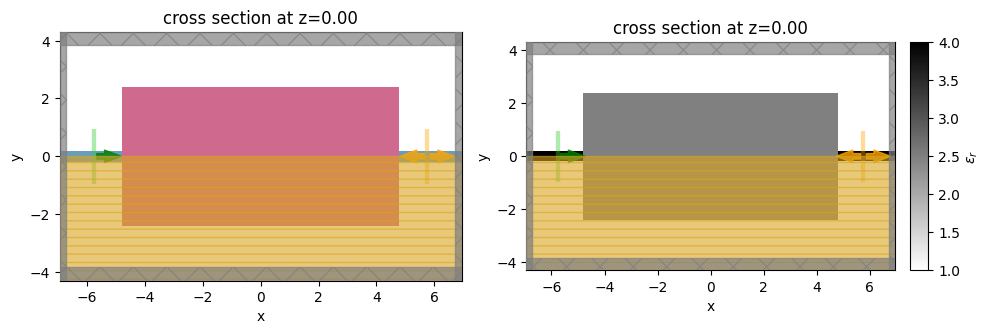

In [11]:
_, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 4))
sim_base.plot(z=0, ax=ax1)
sim_base.plot_eps(z=0, ax=ax2)
plt.show()

## Design Region Parameterization

Next, we define the functions that allow us to generate our design region using topology optimization.

We'll apply several functions that enable us to filter and project our optimization parameters into a permittivity grid, and then turn this permittivity grid into a structure that can be added to our base simnulation as the optimization progresses.

In [12]:
from tidy3d.plugins.autograd.functions import rescale
from tidy3d.plugins.autograd.invdes import make_filter_and_project

# radius of the circular filter (um) and the threshold strength
radius = 0.120  # <= larger radius = bigger feature sizes
beta = 50  # <= higher beta = more binarized
beta_penalty = 10

filter_project = make_filter_and_project(radius=radius, dl=dl_design_region)


def get_density(params: np.ndarray, beta: float) -> np.ndarray:
    """Get the material density values (0, 1) array as a function of the parameters (0, 1)"""
    return filter_project(params, beta)

def get_eps(params: np.ndarray, beta: float) -> np.ndarray:
    """Get the permittivity values (1, eps_mat) array as a function of the parameters (0, 1)"""
    processed_params = get_density(params, beta)
    eps = rescale(processed_params, 1, eps_mat)
    return eps

def get_design_region(params, beta) -> td.Structure:
    """Get the design region evaluted at a set of parameters."""

    eps = get_eps(params, beta=beta).reshape((nx, ny, 1))
    return td.Structure.from_permittivity_array(eps_data=eps, geometry=design_region_static.geometry)

def get_sim(params, beta) -> td.Simulation:
    """Get the design region evaluted at a set of parameters."""
    design_region = get_design_region(params=params, beta=beta)
    new_structures = list(sim_base.structures)
    new_structures[-1] = design_region
    return sim_base.updated_copy(structures=new_structures)

In [13]:
# get simulation at a set of starting parameters and try it out
params0 = np.random.random((nx, ny))
sim0 = get_sim(params0, beta=beta)

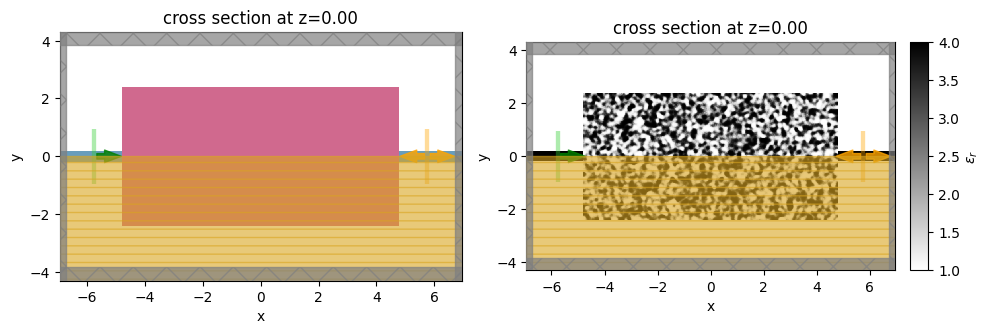

In [14]:
_, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 4))
sim0.plot(z=0, ax=ax1)
sim0.plot_eps(z=0, ax=ax2)
plt.show()

## Objective Function

Next, we will write the code that will define our metric for optimization. Specifically, we will analyze the transmission spectrum of our device, and compute the weighted sum with a set of weights representing our ideal bandpass filter operation.

We'll also include a penalty to discourage small feature sizes, which could be difficult to fabricate.

In [15]:
def get_transmission(
    params, beta, step_num: int, verbose: bool, use_broadband: bool
) -> np.ndarray:
    """Compute transmission amplitudes as function of frequency."""
    sim = get_sim(params=params, beta=beta)
    task_name = "bend_transmission_mf"
    if step_num is not None:
        task_name += "_step_" + str(step_num)
    data = web.run(sim, task_name=task_name, verbose=verbose)
    amps = data[mnt_mode.name].amps.sel(direction="+", mode_index=mode_index)
    if not use_broadband:
        amps = amps.interp(f=freq0)
    return np.abs(amps) ** 2

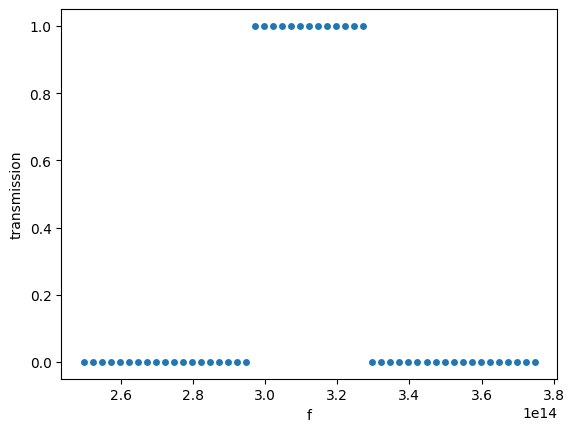

In [16]:
bandwidth_um = 0.1

import xarray as xr

def target(freq: float) -> xr.DataArray:
    """Target transmission as a function of frequency."""
    wvl_min = lambda0 - bandwidth_um / 2.0
    wvl_max = lambda0 + bandwidth_um / 2.0
    wvl = td.C_0 / freq
    values = 1.0 * (np.logical_and(wvl > wvl_min, wvl < wvl_max))
    return xr.DataArray(values, coords=dict(f=freq))

target_spectrum = target(freqs)
target_spectrum.plot.scatter()
plt.ylabel('transmission')
plt.show()

In [17]:
def get_metric(transmission: xr.DataArray) -> float:

    in_band = target_spectrum
    out_band = 1 - target_spectrum

    avg_T_in_band = np.sum(in_band * transmission).values / np.sum(in_band).values
    avg_T_out_band = np.sum(out_band * transmission).values / np.sum(out_band).values

    # ideally,  (avg_T_in_band = 1 and avg_T_out_band = 0) -> metric = 1
    # at worst, (avg_T_in_band = 0 and avg_T_out_band = 1) -> metric = -1
    
    return avg_T_in_band - avg_T_out_band

### Fabrication Penalty

Next, we introduce a builtin fabrication penalty function, that evaluates our design region to reduce our objective function if any small feature sizes are measured compared to the `radius` defined earlier.

In [18]:
from tidy3d.plugins.autograd.invdes import make_erosion_dilation_penalty
penalty = make_erosion_dilation_penalty(radius=radius, dl=dl_design_region, beta=beta_penalty)

In [19]:
# for debugging, can be helpful to be able to change our objective function behavior
use_metric = True
use_penalty = True
use_broadband = True


def objective(
    params: np.ndarray,
    beta: float,
    step_num: int = 0,
    verbose: bool = False,
    use_metric: bool = use_metric,
    use_penalty: bool = use_penalty,
    use_broadband: bool = use_broadband,
) -> float:
    metric = 0.0
    penalty_val = 0.0

    if use_metric:
        transmission = get_transmission(
            params=params,
            beta=beta,
            step_num=step_num,
            verbose=verbose,
            use_broadband=use_broadband,
        )
        metric = get_metric(transmission)

    if use_penalty:
        penalty_weight = 1.0#np.minimum(1, beta / 25)
        density = get_density(params, beta)
        penalty_val = penalty_weight * penalty(density)

    return metric - penalty_val

In [20]:
grad_fn = ag.value_and_grad(objective)

In [21]:
val, grad = grad_fn(params0, beta=beta, verbose=True)
print(grad.shape)

09:48:29 EDT Created task 'bend_transmission_mf_step_0' with task_id            
             'fdve-f4d58556-18f8-4b1f-bb4e-0dd3fcfcf741' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=509779;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f4d58556-18f8-4b1f-bb4e-0dd3fcfcf741\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=396111;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f4d58556-18f8-4b1f-bb4e-0dd3fcfcf741\taskId]8;;\]8;id=509779;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f4d58556-18f8-4b1f-bb4e-0dd3fcfcf741\=]8;;\]8;id=582744;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f4d58556-18f8-4b1f-bb4e-0dd3fcfcf741\fdve]8;;\]8;id=509779;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f4d58556-18f8-4b1f-bb4e-0dd3fcfcf741\-f4d58556-18f]8;;\
             ]8;id=509779;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f4d58556-18f8-4b1f-bb4e-0dd3fcfcf741\8-4b1f-bb4e-0dd3fcfcf741']8;;\.

Output()

09:48:32 EDT status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

09:48:39 EDT status = preprocess

09:48:42 EDT Maximum FlexCredit cost: 0.038. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

09:48:50 EDT early shutoff detected at 16%, exiting.

             status = postprocess

Output()

09:49:02 EDT status = success

09:49:03 EDT View simulation result at                                          
             ]8;id=934000;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f4d58556-18f8-4b1f-bb4e-0dd3fcfcf741\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=375650;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f4d58556-18f8-4b1f-bb4e-0dd3fcfcf741\taskId]8;;\]8;id=934000;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f4d58556-18f8-4b1f-bb4e-0dd3fcfcf741\=]8;;\]8;id=653273;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f4d58556-18f8-4b1f-bb4e-0dd3fcfcf741\fdve]8;;\]8;id=934000;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f4d58556-18f8-4b1f-bb4e-0dd3fcfcf741\-f4d58556-18f]8;;\
             ]8;id=934000;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f4d58556-18f8-4b1f-bb4e-0dd3fcfcf741\8-4b1f-bb4e-0dd3fcfcf741']8;;\.

Output()

09:49:09 EDT loading simulation from simulation_data.hdf5

09:49:12 EDT Created task 'bend_transmission_mf_step_0_adjoint' with task_id    
             'fdve-7dec0c82-3d06-480a-bfe7-f0ab34f27c66' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=488957;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7dec0c82-3d06-480a-bfe7-f0ab34f27c66\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=738549;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7dec0c82-3d06-480a-bfe7-f0ab34f27c66\taskId]8;;\]8;id=488957;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7dec0c82-3d06-480a-bfe7-f0ab34f27c66\=]8;;\]8;id=275992;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7dec0c82-3d06-480a-bfe7-f0ab34f27c66\fdve]8;;\]8;id=488957;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7dec0c82-3d06-480a-bfe7-f0ab34f27c66\-7dec0c82-3d0]8;;\
             ]8;id=488957;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7dec0c82-3d06-480a-bfe7-f0ab34f27c66\6-480a-bfe7-f0ab34f27c66']8;;\.

Output()

09:49:19 EDT status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

09:49:24 EDT status = preprocess

09:49:27 EDT Maximum FlexCredit cost: 0.029. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

09:49:33 EDT early shutoff detected at 16%, exiting.

             status = postprocess

Output()

09:49:44 EDT status = success

             View simulation result at                                          
             ]8;id=424396;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7dec0c82-3d06-480a-bfe7-f0ab34f27c66\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=773577;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7dec0c82-3d06-480a-bfe7-f0ab34f27c66\taskId]8;;\]8;id=424396;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7dec0c82-3d06-480a-bfe7-f0ab34f27c66\=]8;;\]8;id=958448;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7dec0c82-3d06-480a-bfe7-f0ab34f27c66\fdve]8;;\]8;id=424396;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7dec0c82-3d06-480a-bfe7-f0ab34f27c66\-7dec0c82-3d0]8;;\
             ]8;id=424396;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7dec0c82-3d06-480a-bfe7-f0ab34f27c66\6-480a-bfe7-f0ab34f27c66']8;;\.

Output()

09:49:52 EDT loading simulation from simulation_data.hdf5

(640, 320)


In [22]:
print(np.linalg.norm(grad))
val

0.10912602161644087


-0.7627931213846738

## Optimization

Now that we have a function to compute our gradient, we can use an open source gradient-based optimizer to perform inverse design of our device.

In this case, we use the `optax` package to implement the "adam" optimization algorithm, which performs gradient-ascent with some extra terms to improve the performance and convergence.

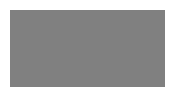

step = 1
	beta = 1.0000e+00
	J = -1.1031e+00
	grad_norm = 2.6937e-02


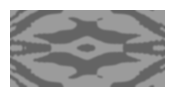

step = 2
	beta = 2.4412e+00
	J = -9.3951e-01
	grad_norm = 3.2958e-02


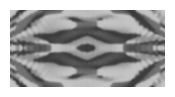

step = 3
	beta = 3.8824e+00
	J = -9.2547e-01
	grad_norm = 3.6467e-02


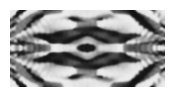

step = 4
	beta = 5.3235e+00
	J = -5.6463e-01
	grad_norm = 4.7341e-02


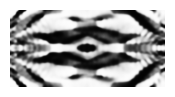

step = 5
	beta = 6.7647e+00
	J = -4.2856e-01
	grad_norm = 3.2930e-02


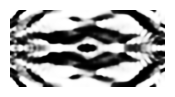

step = 6
	beta = 8.2059e+00
	J = -3.7870e-01
	grad_norm = 1.7932e-02


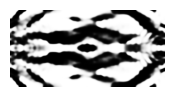

step = 7
	beta = 9.6471e+00
	J = -2.1434e-01
	grad_norm = 2.2961e-02


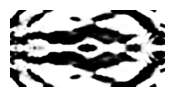

step = 8
	beta = 1.1088e+01
	J = -8.9146e-02
	grad_norm = 2.2606e-02


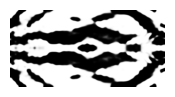

step = 9
	beta = 1.2529e+01
	J = 1.2102e-02
	grad_norm = 2.2039e-02


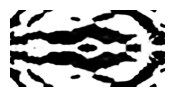

step = 10
	beta = 1.3971e+01
	J = 1.1254e-01
	grad_norm = 2.0333e-02


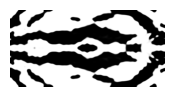

step = 11
	beta = 1.5412e+01
	J = 1.9403e-01
	grad_norm = 2.1584e-02


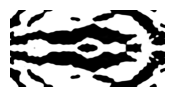

step = 12
	beta = 1.6853e+01
	J = 2.7036e-01
	grad_norm = 2.1661e-02


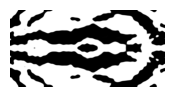

In [ ]:
# assert False
import optax

# hyperparameters
num_steps = 35
learning_rate = 0.1

# initialize adam optimizer with starting parameters
params = np.ones_like(params0) * 0.5
optimizer = optax.adam(learning_rate=learning_rate)
opt_state = optimizer.init(params)

# store history
objective_history = []
params_history = [params]
beta_history = []

# gradually increase the binarization strength
beta0 = 1
beta_max = 50

for i in range(num_steps):
    # compute gradient and current objective funciton value

    density = get_density(params, beta)

    plt.subplots(1, 1, figsize=(2, 2))
    plt.imshow(np.flipud(1 - density.T), cmap="gray", vmin=0, vmax=1)
    plt.axis("off")
    plt.show()

    perc_done = (i / (num_steps - 1))
    
    beta = beta0 + perc_done * (beta_max - beta0)
    value, gradient = grad_fn(
        np.array(params),
        step_num=i + 1,
        beta=beta,
    )

    # outputs
    print(f"step = {i + 1}")
    print(f"\tbeta = {beta:.4e}")
    print(f"\tJ = {value:.4e}")
    print(f"\tgrad_norm = {np.linalg.norm(gradient):.4e}")

    # compute and apply updates to the optimizer based on gradient (-1 sign to maximize obj_fn)
    updates, opt_state = optimizer.update(-gradient, opt_state, params)
    params = optax.apply_updates(params, updates)

    # cap the parameters
    params = np.clip(params, 0.0, 1.0)

    # save history
    objective_history.append(value)
    params_history.append(params)
    beta_history.append(beta)

power = objective(params_history[-1], beta=beta)
objective_history.append(power)

In [ ]:
params_final = params_history[-1]

## Analyzing Results

Now we can take a look at our optimization results and make some figures.

We'll first plot the objective function value history, and then look at the transmission spectrum and field profiles of our final device.

In [ ]:
plt.plot(objective_history)
plt.xlabel("iterations")
plt.ylabel("objective function")
plt.show()

In [ ]:
mnt_fld = td.FieldMonitor(
    size=(td.inf, td.inf, 0), center=(0, 0, 0), freqs=[fmin, freq0, fmax], name="fields"
)

sim_final = get_sim(params_final, beta=beta)

sim_final = sim_final.updated_copy(monitors=list(sim_final.monitors) + [mnt_fld])

In [ ]:
sim_final.plot_eps(z=0, monitor_alpha=0.0, source_alpha=0.0)
plt.show()

In [ ]:
transmission = get_transmission(
    params=params_final, beta=beta, step_num=None, verbose=True, use_broadband=True
)

In [ ]:
plt.scatter(freqs / 1e12, target(freqs), label="target")
plt.plot(freqs / 1e12, transmission, label="measured")
plt.xlabel("frequency (THz)")
plt.ylabel("transmission (P_out / P_in)")
plt.legend()
plt.show()

We see that the final transmission spectrum more or less matches our expected bandpass filter!

In [ ]:
sim_data_final = web.run(sim_final, task_name="final")

In [ ]:
f, axes = plt.subplots(3, 1, tight_layout=True, figsize=(10, 6))

for ax, f in zip(axes, (mnt_fld.freqs)):
    sim_data_final.plot_field(mnt_fld.name, field_name="E", val="abs^2", f=f, ax=ax)
    ax.set_title(f"wvl={1000 * f/td.C_0:.0f} (nm)")

We see that the field patterns at the middle and edges of our spectrum behave as we would expect, respectively blocking and transmitting the light.

## Using Inverse Design Plugin

Tidy3D now supports a higher level syntax for defining inverse design problems in a simpler way.

Here we'll show how to set up this same problem using that tool and run it for 2 iterations.

For a full tutorial, refer to [this example](https://docs.simulation.cloud/projects/tidy3d/en/latest/notebooks/InverseDesign.html).

In [ ]:
import tidy3d.plugins.invdes as tdi

In [ ]:
# transformations on the parameters that lead to the material density array (0,1)
filter_project = tdi.FilterProject(radius=radius, beta=beta_history[-1])

# penalties applied to the state of the material density, after these transformations are applied
penalty = tdi.ErosionDilationPenalty(weight=1.0, length_scale=radius)

design_region = tdi.TopologyDesignRegion(
        size=design_region_static.geometry.size,
        center=design_region_static.geometry.center,
        eps_bounds=(1.0, eps_mat), # the minimum and maximum permittivity values in the final grid
        transformations=[filter_project],
        penalties=[penalty],
        pixel_size=dl_design_region,
    )

In [ ]:
objective_function = 0.0
for f in freqs:
    objective_function += ModePower(
        monitor_name="mode",
        direction='-',
        freqs=[f],
    )


In [ ]:
design = tdi.InverseDesign(
    simulation=sim_base,
    design_region=design_region,
    task_name="invdes",
    metric=objective_function,
)

In [ ]:
optimizer = tdi.AdamOptimizer(
    design=design,
    num_steps=1,
    learning_rate=learning_rate,
    results_cache_fname="data/invdes_history_filter.hdf5",
)

In [ ]:
result = optimizer.run(params0=params_history[-1].reshape((nx, ny, 1)), post_process_fn=post_process_fn)

In [ ]:
sim_last = result.sim_last
ax = sim_last.plot_eps(z=0, monitor_alpha=0.0, source_alpha=0.0)